# Experimentos para os dados estruturados

In [8]:
import datetime
import re
import json
import yaml
import sys
import os
import logging
import logging.config
import time
import multiprocessing
from collections import OrderedDict
import requests
import sqlalchemy
import string
import unicodedata
import yaml
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import tqdm

import numpy as np
from scipy.sparse import issparse

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    balanced_accuracy_score,
    average_precision_score,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    jaccard_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
)
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import joblib
from joblib import delayed, Parallel

#################################
# VARIÁVEIS GLOBAIS
#################################
N_JOBS = -1
BASE_DIR = './'
DEFAULT_RANDOM_STATE = 42

#################################
# LOGS
#################################
with open(os.path.join(BASE_DIR, 'log.conf.yaml'), 'r') as f:
    config = yaml.safe_load(f.read())
    logging.config.dictConfig(config)
    
#################################
# CONFIGURAÇÕES
#################################
pd.options.display.max_rows = 500

In [10]:
# # Leitura dos dados estruturados extraídos das denúncias. 
# # Informações completamente anonimizadas.
# df = pd.read_parquet('datasets/df_treinamento_faro.parquet')
# df['LABEL'] = df['GrauAptidao'].apply(lambda x: 1 if x > 50 else 0)
# df.drop(columns=['IdManifestacao','GrauAptidao','TxtFatoManifestacao','TextoAnexo'], inplace=True)
# df.columns = [f'F{i:>03}' for i, c in enumerate(df.columns[:-1])] + ['LABEL']

In [11]:
# # Divisão dos dados em treino e teste
# X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['LABEL']), df['LABEL'], test_size=.2, random_state=DEFAULT_RANDOM_STATE, stratify=df['LABEL'])

# # altera a escala das features para um intervalo entre 0 e 1.

# X_train_original = X_train.copy()
# X_test_original = X_test.copy()

# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# NUMERO_FEATURES = X_train.shape[1]

In [12]:
# df_tmp = pd.DataFrame(X_train, columns=X_train_original.columns, index=X_train_original.index)
# df_tmp['LABEL'] = y_train
# df_tmp.to_parquet('datasets/df_train_de.parquet')

# df_tmp = pd.DataFrame(X_test, columns=X_test_original.columns, index=X_test_original.index)
# df_tmp['LABEL'] = y_test
# df_tmp.to_parquet('datasets/df_test_de.parquet')

In [13]:
df_train = pd.read_parquet('datasets/df_train_de.parquet')
X_train, y_train = df_train.drop(columns=['LABEL']), df_train['LABEL']

df_test = pd.read_parquet('datasets/df_test_de.parquet')
X_test, y_test = df_test.drop(columns=['LABEL']), df_test['LABEL']

NUMERO_FEATURES = X_train.shape[1]

# Escolha de features

In [14]:
# métricas utilizadas para avaliação
metrics = ['average_precision','balanced_accuracy','roc_auc']

k_vs_avg_prec_score = []
k_vs_bal_acc_score = []
k_vs_roc_auc_score = []

# cálculo do peso para a classe positiva (utilizado em algoritmos que podem lidar com o dataset desbalanceado)
POS_WEIGHT = y_train.value_counts()[0]/y_train.value_counts()[1]
class_weight = {0: 1, 1: POS_WEIGHT}

for k in tqdm.tqdm_notebook(range(2, NUMERO_FEATURES + 1, 2)):
    
    # seleciona k features utilizando SelectFromModel(RandomForestClassifier)
    selector = SelectFromModel(
        RandomForestClassifier(
            n_estimators=500, 
            class_weight=class_weight, 
            random_state=DEFAULT_RANDOM_STATE, 
            n_jobs=N_JOBS), 
        max_features=k, 
        threshold=-np.inf)
    selector.fit(X_train, y_train)
    
    # transforma o dataset para preservar apenas as features selecionadas
    X_train_fs = selector.transform(X_train)
    
    # realiza validação cruzada com 10 folds estratificados
    rskfcv = RepeatedStratifiedKFold(
        n_splits=10, 
        n_repeats=1, 
        random_state=DEFAULT_RANDOM_STATE)
    
    valores = cross_validate(
        RandomForestClassifier(
            n_estimators=500, 
            class_weight=class_weight, 
            random_state=DEFAULT_RANDOM_STATE, 
            n_jobs=N_JOBS), 
        X_train_fs, 
        y_train, 
        scoring=metrics, 
        cv=rskfcv, 
        n_jobs=N_JOBS
    )
    cv_scores = {k[5:]: np.mean(v) for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    avg_prec, bal_acc, roc_auc = cv_scores['average_precision'],cv_scores['balanced_accuracy'],cv_scores['roc_auc']
    
    logging.info("k = {} - average_precision = {} - balanced_accuracy = {} - roc_auc_score = {}".format(k, avg_prec, bal_acc, roc_auc))
    
    k_vs_avg_prec_score.append(avg_prec)
    k_vs_bal_acc_score.append(bal_acc)
    k_vs_roc_auc_score.append(roc_auc)

  0%|          | 0/63 [00:00<?, ?it/s]

[2021-10-13 15:23:18,226][3870253579.py:<module>:49 INFO] k = 2 - average_precision = 0.36249257248836436 - balanced_accuracy = 0.5537127524633829 - roc_auc_score = 0.5434770301089318
[2021-10-13 15:23:24,747][3870253579.py:<module>:49 INFO] k = 4 - average_precision = 0.45642008264144424 - balanced_accuracy = 0.6052382442037698 - roc_auc_score = 0.6800736789129018
[2021-10-13 15:23:30,864][3870253579.py:<module>:49 INFO] k = 6 - average_precision = 0.48970079094754143 - balanced_accuracy = 0.6212838003044421 - roc_auc_score = 0.712935199264046
[2021-10-13 15:23:36,893][3870253579.py:<module>:49 INFO] k = 8 - average_precision = 0.4921078820193383 - balanced_accuracy = 0.6107609217876429 - roc_auc_score = 0.7163226273348722
[2021-10-13 15:23:43,382][3870253579.py:<module>:49 INFO] k = 10 - average_precision = 0.4938304687918653 - balanced_accuracy = 0.6132872549564452 - roc_auc_score = 0.7194022142941277
[2021-10-13 15:23:49,880][3870253579.py:<module>:49 INFO] k = 12 - average_precisi

In [15]:
# resumo das métricas
df_feature_selection = pd.DataFrame({
    'Número de Features': range(2, NUMERO_FEATURES + 1, 2),
    'Average Precision': k_vs_avg_prec_score,
    'Balanced Accuracy': k_vs_bal_acc_score,
    'ROC AUC': k_vs_roc_auc_score,
})

df_feature_selection[df_feature_selection['Número de Features']%10==0].reset_index(drop=True)

,Número de Features,Average Precision,Balanced Accuracy,ROC AUC
0,10,0.493830,0.613287,0.719402
1,20,0.496216,0.614930,0.721389
2,30,0.496554,0.619865,0.722348
3,40,0.499383,0.622168,0.724124
4,50,0.499596,0.625196,0.724926
5,60,0.500968,0.624654,0.725408
6,70,0.499691,0.629115,0.725258
7,80,0.500313,0.626785,0.724844
8,90,0.501906,0.630631,0.725921
9,100,0.500118,0.622137,0.724129


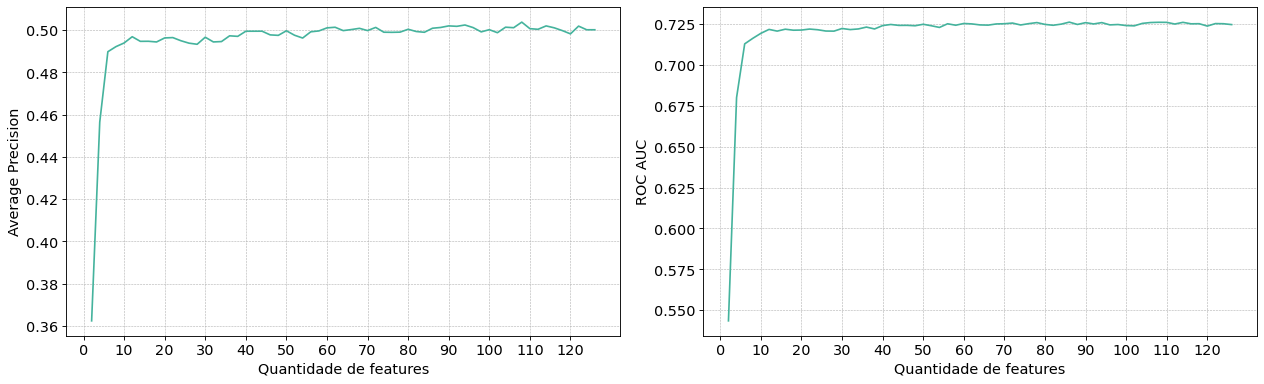

In [16]:
# gráfico com as métricas

tamanho_vetores = range(2, NUMERO_FEATURES + 1, 2)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,2, figsize=(16, 5), dpi=80)
t = list(range(0, NUMERO_FEATURES + 1, 10))

pd.Series(k_vs_avg_prec_score[0:],index=tamanho_vetores).plot(color='#45B39D', ax=ax[0])
ax[0].set_xlabel('Quantidade de features')
ax[0].set_ylabel('Average Precision')
ax[0].grid(which='major',linestyle='--', linewidth=0.5)
ax[0].set_xticks(t)

pd.Series(k_vs_roc_auc_score[0:],index=tamanho_vetores).plot(color='#45B39D', ax=ax[1])
ax[1].set_xlabel('Quantidade de features')
ax[1].set_ylabel('ROC AUC')
ax[1].grid(which='major',linestyle='--', linewidth=0.5)
ax[1].set_xticks(t)
plt.tight_layout()
plt.savefig('./fig_selecao_features.png')
plt.show()

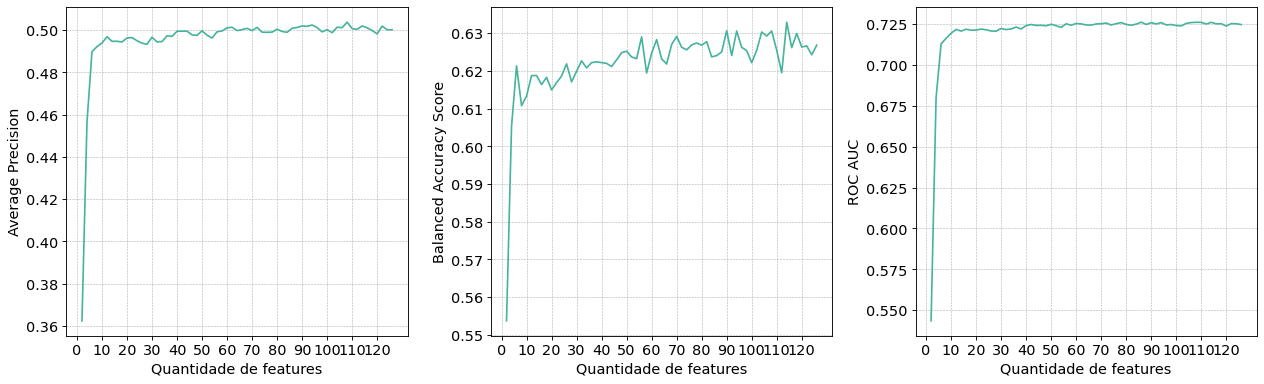

In [17]:
# gráfico com as métricas

tamanho_vetores = range(2, NUMERO_FEATURES + 1, 2)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(1,3, figsize=(16, 5), dpi=80)
t = list(range(0, NUMERO_FEATURES + 1, 10))

pd.Series(k_vs_avg_prec_score[0:],index=tamanho_vetores).plot(color='#45B39D', ax=ax[0])
ax[0].set_xlabel('Quantidade de features')
ax[0].set_ylabel('Average Precision')
ax[0].grid(which='major',linestyle='--', linewidth=0.5)
ax[0].set_xticks(t)

pd.Series(k_vs_bal_acc_score[0:],index=tamanho_vetores).plot(color='#45B39D', ax=ax[1])
ax[1].set_xlabel('Quantidade de features')
ax[1].set_ylabel('Balanced Accuracy Score')
ax[1].grid(which='major',linestyle='--', linewidth=0.5)
ax[1].set_xticks(t)

pd.Series(k_vs_roc_auc_score[0:],index=tamanho_vetores).plot(color='#45B39D', ax=ax[2])
ax[2].set_xlabel('Quantidade de features')
ax[2].set_ylabel('ROC AUC')
ax[2].grid(which='major',linestyle='--', linewidth=0.5)
ax[2].set_xticks(t)
plt.tight_layout()
plt.show()

# Escolha de um modelo

In [18]:
# seleciona k features utilizando SelectFromModel(RandomForestClassifier)

k = 20

selector_model=RandomForestClassifier(
    n_estimators=1000, 
    class_weight=class_weight, 
    random_state=DEFAULT_RANDOM_STATE, 
    n_jobs=N_JOBS)

selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)
selector.fit(X_train, y_train)

X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

In [19]:
X_train.shape

(3240, 20)

In [20]:
# realiza testes com validação cruzada para a escolha do modelo

metrics = ['roc_auc','balanced_accuracy', 'average_precision', 'recall', 'accuracy', 'f1_macro','f1_weighted']

results = [
    
]

model = [
    RandomForestClassifier,
    LogisticRegression,
    XGBClassifier,
    KNeighborsClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    SGDClassifier,
    SVC, 
    NuSVC, 
    LinearSVC,
    BernoulliNB, 
    LGBMClassifier,
    MLPClassifier,
    AdaBoostClassifier,
]


params = [
    {
        'n_estimators': [1000],
        'max_depth': [5,7,9],
        'min_samples_split': [2,3],
        'min_samples_leaf': [1,2],
        'class_weight': [class_weight],
        'random_state': [DEFAULT_RANDOM_STATE],
        'max_samples': [.8, 1],
    },
    {
        'penalty' : ['l2'],
        'C' : [1],
        'solver' : ['liblinear'],
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'learning_rate': [0.01],
        'n_estimators': [1000],
        'subsample' : [.8,.45],
        'min_child_weight': [1],
        'max_depth': [3,4,7],
        'random_state': [DEFAULT_RANDOM_STATE],
        'reg_lambda': [2],
        'scale_pos_weight': [POS_WEIGHT]
    },
    {
        'n_neighbors' : [5,7,9,11],
    },
    {
        'n_estimators': [1000],
        'max_samples': [.8],
        'random_state': [DEFAULT_RANDOM_STATE],
    },
    {
        'n_estimators': [1000],
        'max_samples' : [.8],
        'max_depth': [6,7],
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'gamma': ['auto'],
        'C': [0.5],
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'gamma': ['auto'],
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
    },
    {
        'n_estimators': [1000],
        'subsample': [.6,.7,.8,1],
        'random_state': [DEFAULT_RANDOM_STATE],
        'class_weight': [class_weight],
    },
    {
        'alpha': [1], 
        'max_iter': [1000],
    },
    {
    }
]

import pdb

logging.info('Início')

# itera a lista de modelos e seus hiperparâmetros
lista_mh = list(zip(model, params))
for m, p in tqdm.tqdm_notebook(lista_mh):
    logging.info('Modelo: {}'.format(m.__name__))
    
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    
    # utiliza o GridSearchCV para encontrar o melhor conjunto de hiperparâmetros 
    # que maximizem o roc_auc score
    cv = GridSearchCV(estimator=m(),param_grid=p, n_jobs=N_JOBS, error_score=0, refit=True, scoring='roc_auc', cv=rskfcv)
    cv.fit(X_train, y_train)
    model = cv.best_estimator_
    best_params = cv.best_params_
    
    # instancia o modelo com os hiperparâmetros escolhidos acima e utiliza validação cruzada 
    # para avaliar todas as métricas escolhidas
    valores = cross_validate(m(**best_params), X_train, y_train, scoring=metrics, cv=rskfcv)
    cv_scores = {k[5:]: np.mean(v) for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    
    # monta um registro com todas as informações coletadas para comparação
    linha = {
        'Modelo': m.__name__,
        'ScoreTreino': cv.score(X_train, y_train),
        'BestParams': best_params,
        'RawScores': {k[5:]: v for k, v in valores.items() if k not in ['fit_time', 'score_time']}
    }
    linha.update(cv_scores)
    results.append(linha)
    

[2021-10-13 15:31:09,565][1695454547.py:<module>:106 INFO] Início


  0%|          | 0/14 [00:00<?, ?it/s]

[2021-10-13 15:31:09,605][1695454547.py:<module>:111 INFO] Modelo: RandomForestClassifier
[2021-10-13 15:33:29,524][1695454547.py:<module>:111 INFO] Modelo: LogisticRegression
[2021-10-13 15:33:29,740][1695454547.py:<module>:111 INFO] Modelo: XGBClassifier
[2021-10-13 15:34:20,489][1695454547.py:<module>:111 INFO] Modelo: KNeighborsClassifier
[2021-10-13 15:34:21,431][1695454547.py:<module>:111 INFO] Modelo: BaggingClassifier
[2021-10-13 15:36:33,932][1695454547.py:<module>:111 INFO] Modelo: ExtraTreesClassifier
[2021-10-13 15:37:02,346][1695454547.py:<module>:111 INFO] Modelo: SGDClassifier
[2021-10-13 15:37:02,751][1695454547.py:<module>:111 INFO] Modelo: SVC
[2021-10-13 15:37:09,610][1695454547.py:<module>:111 INFO] Modelo: NuSVC
[2021-10-13 15:37:13,219][1695454547.py:<module>:111 INFO] Modelo: LinearSVC
[2021-10-13 15:37:13,614][1695454547.py:<module>:111 INFO] Modelo: BernoulliNB
[2021-10-13 15:37:13,793][1695454547.py:<module>:111 INFO] Modelo: LGBMClassifier
[2021-10-13 15:37:3

In [21]:
# tabela comparativa com os resultados apresentados por cada algoritmo executado
df_results = pd.DataFrame(results)
df_results.sort_values('roc_auc', ascending=False)

,Modelo,ScoreTreino,BestParams,RawScores,roc_auc,balanced_accuracy,average_precision,recall,accuracy,f1_macro,f1_weighted
2,XGBClassifier,0.830993,"{'learning_rate': 0.01, 'max_depth': 3, 'min_c...","{'roc_auc': [0.7402914839181286, 0.78458516081...",0.765958,0.701978,0.570179,0.729532,0.690741,0.668653,0.703332
0,RandomForestClassifier,0.806853,"{'class_weight': {0: 1, 1: 2.371488033298647},...","{'roc_auc': [0.7424616228070176, 0.78280336257...",0.765190,0.696533,0.568661,0.752427,0.673765,0.655904,0.687638
5,ExtraTreesClassifier,0.778812,"{'class_weight': {0: 1, 1: 2.371488033298647},...","{'roc_auc': [0.7394005847953217, 0.76649305555...",0.753107,0.675729,0.548128,0.644126,0.688580,0.656361,0.698997
13,AdaBoostClassifier,0.783375,{},"{'roc_auc': [0.7344206871345028, 0.76009685672...",0.751085,0.625982,0.533068,0.367365,0.731173,0.634903,0.711094
1,LogisticRegression,0.739525,"{'C': 1, 'class_weight': {0: 1, 1: 2.371488033...","{'roc_auc': [0.7344663742690059, 0.74995431286...",0.738548,0.640081,0.509622,0.482861,0.704012,0.641479,0.702242
9,LinearSVC,0.739214,"{'class_weight': {0: 1, 1: 2.371488033298647},...","{'roc_auc': [0.7365222953216374, 0.75484283625...",0.737177,0.640378,0.515054,0.475558,0.707407,0.642709,0.704431
6,SGDClassifier,0.733293,"{'class_weight': {0: 1, 1: 2.371488033298647},...","{'roc_auc': [0.7334612573099415, 0.75141630116...",0.735213,0.629989,0.510925,0.456948,0.700309,0.626468,0.691340
12,MLPClassifier,0.733795,"{'alpha': 1, 'max_iter': 1000}","{'roc_auc': [0.7298062865497076, 0.74588815789...",0.734123,0.556386,0.503451,0.170683,0.713272,0.540850,0.655256
4,BaggingClassifier,0.990785,"{'max_samples': 0.8, 'n_estimators': 1000, 'ra...","{'roc_auc': [0.6921600877192982, 0.78508771929...",0.727718,0.624895,0.510633,0.428812,0.704630,0.629295,0.697157
7,SVC,0.728054,"{'C': 0.5, 'class_weight': {0: 1, 1: 2.3714880...","{'roc_auc': [0.7249634502923976, 0.73633954678...",0.726581,0.614925,0.494911,0.382968,0.709259,0.620914,0.695206


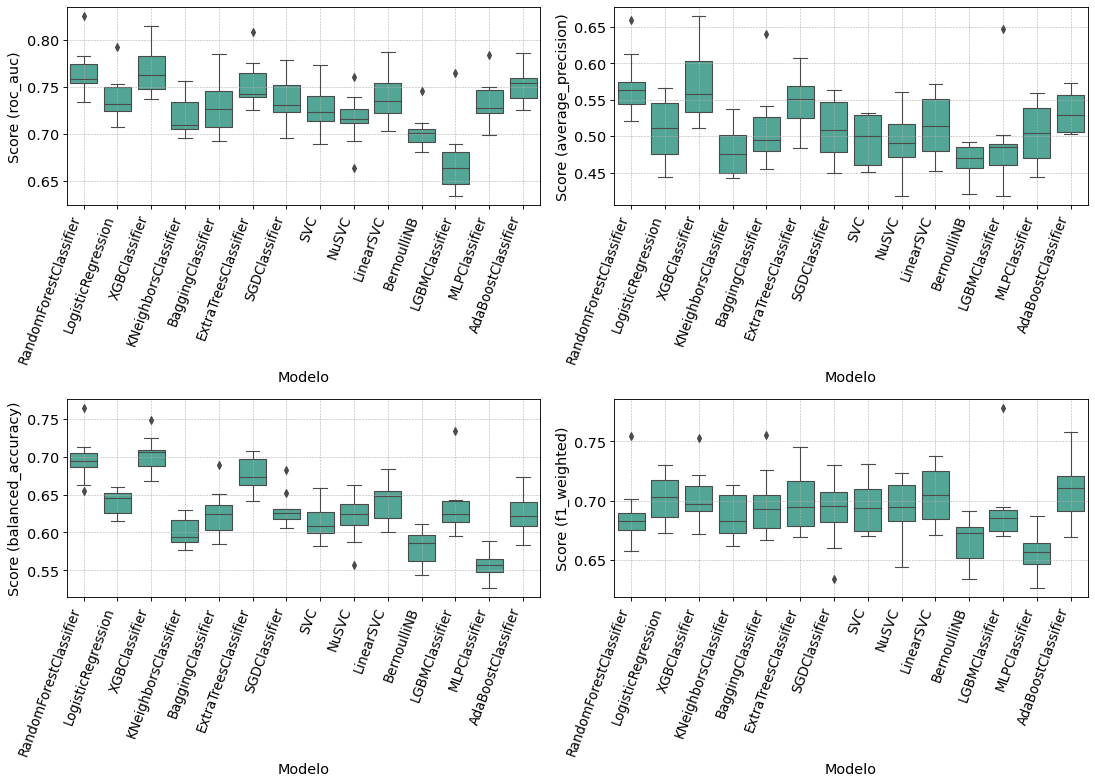

In [22]:
metricas = ['roc_auc', 'average_precision', 'balanced_accuracy', 'f1_weighted' ]

matplotlib.rcParams.update({'font.size': 13})
fig, axis = plt.subplots(2,2, figsize=(14, 10), dpi=80)

axis = np.ravel(axis)
for i, m in enumerate(metricas):
    df_score = pd.DataFrame({m: s for m, s in zip(df_results['Modelo'], df_results['RawScores'].apply(lambda x: x[m]))})
    df_score = pd.melt(df_score, var_name='Modelo', value_name='Score')
    sns.boxplot(x='Modelo', y='Score', data=df_score, color='#45B39D', linewidth=1, ax=axis[i])
    axis[i].set_xlabel('Modelo')
    axis[i].set_ylabel(f'Score ({m})')
    axis[i].set_xticklabels(labels=df_score['Modelo'].drop_duplicates(), rotation=70, ha='right', fontsize=12)
    axis[i].grid(which='major',linestyle='--', linewidth=0.5, )
    
plt.tight_layout()
plt.show()

# Tunning de Hiperparâmetros

In [23]:
from skopt import forest_minimize


def funcao_otimizacao(params):
    """
    Esta funcao recebe os hiperpâmetros selecionados pela função forest_minimize,
    instancia o RandomForestClassifier com os parâmetros recebidos e avalia o
    modelo com os dados de treino utilizando validação cruzada com 10 folds.
    """
    logging.info(params)
    n_estimators = params[0] 
    max_depth = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_samples = params[4]
    class_weight = {0: 1, 1: params[5]}
    
    model = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_samples=max_samples,
                                 class_weight=class_weight,
                                 random_state=DEFAULT_RANDOM_STATE, 
                                 n_jobs=-1)
    rskfcv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=DEFAULT_RANDOM_STATE)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=rskfcv)
    return -np.mean(score)

space = [
    (200, 3000), # n_estimators
    (1, 10),     # max_depth
    (2, 20),     # min_samples_split
    (1, 20),     # min_samples_leaf
    (0.4, 1.),   # max_samples
    (2, 10),     # class_weight
]

N_CALLS = 50
pbar = tqdm.tqdm_notebook(total=N_CALLS)
def atualizar_progresso(res):
    pbar.update(1)
    
res = forest_minimize(funcao_otimizacao, space, random_state=DEFAULT_RANDOM_STATE, n_random_starts=10, n_calls=N_CALLS, verbose=1, n_jobs=N_JOBS, callback=atualizar_progresso)
pbar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
[2021-10-13 15:38:04,017][28608279.py:funcao_otimizacao:10 INFO] [1060, 8, 8, 19, 0.45998494949080176, 9]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.1096
Function value obtained: -0.7620
Current minimum: -0.7620
Iteration No: 2 started. Evaluating function at random point.
[2021-10-13 15:38:19,126][28608279.py:funcao_otimizacao:10 INFO] [330, 6, 3, 12, 0.9631316254094502, 3]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.6622
Function value obtained: -0.7663
Current minimum: -0.7663
Iteration No: 3 started. Evaluating function at random point.
[2021-10-13 15:38:26,788][28608279.py:funcao_otimizacao:10 INFO] [1415, 5, 2, 12, 0.7669918962929686, 10]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.7622
Function value obtained: -0.7646
Current minimum: -0.7663
Iteration No: 4 started. Evaluating function at random point.
[2021-10-13 15:38:47,550][28608279.

In [24]:
res.x

[2958, 6, 2, 5, 0.5019469401405005, 3]

In [25]:
X_train.shape

(3240, 20)

In [26]:
X_test.shape

(811, 20)

In [27]:
params = [2412, 6, 14, 5, 0.5006957711150638, 2]
params = res.x

n_estimators = params[0] 
max_depth = params[1]
min_samples_split = params[2]
min_samples_leaf = params[3]
max_samples = params[4]
class_weight = {0: 1, 1: params[5]}


model = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_samples=max_samples,
                             class_weight=class_weight,
                             random_state=DEFAULT_RANDOM_STATE, 
                             n_jobs=-1)

model.fit(X_train, y_train)

p = model.predict(X_test)

In [28]:
balanced_accuracy_score(y_test, p)

0.7009026716168014

In [29]:
accuracy_score(y_test, p)

0.6485819975339088

In [30]:
f1_score(y_test, p)

0.5839416058394161

In [31]:
recall_score(y_test, p)

0.8298755186721992

In [32]:
precision_score(y_test, p)

0.45045045045045046

In [33]:
accuracy_score(y_test, p)

0.6485819975339088

In [34]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.7839884982164955

In [35]:
pd.DataFrame(confusion_matrix(y_test, p), columns=['Predito como Falso','Predito como Verdadeiro'], index=['Falso', 'Verdadeiro'])

,Predito como Falso,Predito como Verdadeiro
Falso,326,244
Verdadeiro,41,200


In [36]:
print(classification_report(y_test, p))

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       570
           1       0.45      0.83      0.58       241

    accuracy                           0.65       811
   macro avg       0.67      0.70      0.64       811
weighted avg       0.76      0.65      0.66       811



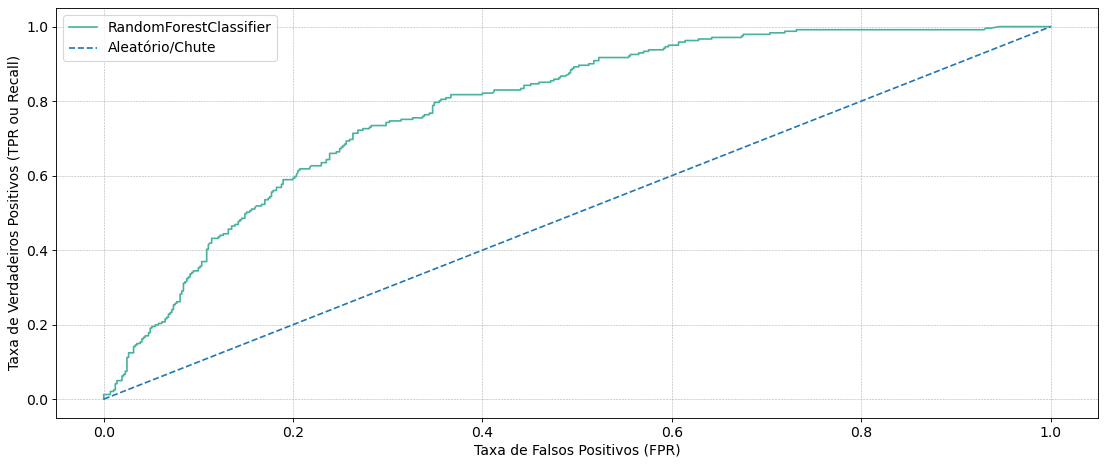

In [37]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
# plt.title(' Curva Característica de Operação do Receptor (ROC)')
lr_fpr, lr_tpr, thresholds =  roc_curve(y_test.values, model.predict_proba(X_test)[:,1], drop_intermediate=False, pos_label=1)
plt.plot(lr_fpr, lr_tpr, label='RandomForestClassifier',color='#45B39D')
plt.plot([0, 1], [0,1], linestyle='--', label='Aleatório/Chute')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.grid(which='major',linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [38]:
df_histograma = pd.Series(model.predict_proba(X_test)[:,1]).to_frame().rename(columns={0:'Score'})
df_histograma['Bins'] = pd.cut(df_histograma['Score'], bins=np.arange(0,1.05,0.05))
df_histograma['Y'] = y_test.values
df_histograma['Acertos Thr 0.5'] = df_histograma.apply(lambda x: 1 if (1 if x['Score']>=.5 else 0)==x['Y'] else 0,axis=1)

In [39]:
df_barplot = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).apply(lambda x: x['Acertos Thr 0.5'].sum()/x.shape[0]).fillna(0).to_frame().rename(columns={0: 'Acertos (%)'})
df_barplot['Contagem'] = df_histograma[['Bins','Acertos Thr 0.5']].groupby(['Bins']).count()
df_barplot = df_barplot.reset_index()
df_barplot['left'] = df_barplot['Bins'].apply(lambda x: x.left+0.025)

In [40]:
N = 20
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(.5,45/256, N)
vals[:, 1] = np.linspace(0, 179/256, N)
vals[:, 2] = np.linspace(0, 157/256, N)
newcmp = ListedColormap(vals)

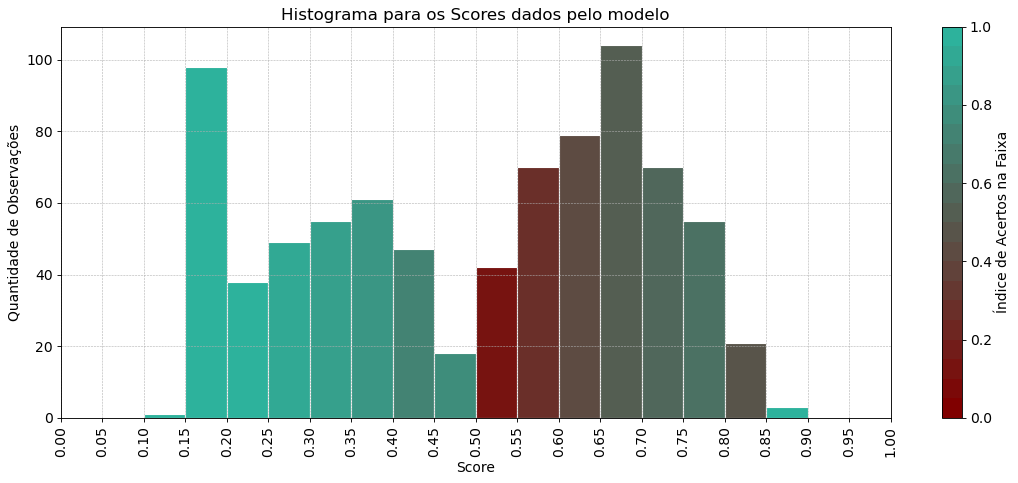

In [41]:
matplotlib.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(14, 6), dpi=80)
color='#45B39D'
scalarMappable = ScalarMappable(cmap=newcmp)
plt.bar(df_barplot['left'], df_barplot['Contagem'], width=0.05, color=scalarMappable.cmap(df_barplot['Acertos (%)']), alpha=1, linewidth=1, edgecolor='white')
colorbar = plt.colorbar(scalarMappable)
colorbar.set_label('Índice de Acertos na Faixa')
plt.xlim(0,1)
plt.grid(which='both',linestyle='--', linewidth=0.5)
plt.title('Histograma para os Scores dados pelo modelo')
plt.xlabel('Score')
plt.ylabel('Quantidade de Observações')
plt.tight_layout()
plt.xticks(ticks=np.arange(0,1.05, 0.05), rotation=90)
plt.show()